In [6]:
#@markdown ### **Imports**
# diffusion policy import
from typing import Tuple, Sequence, Dict, Union, Optional, Callable
import numpy as np
import math
import torch
import torch.nn as nn
import torchvision
import collections
import zarr
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler
from tqdm import tqdm
from PIL import Image
from skvideo.io import vwrite
from IPython.display import Video

import cv2
import pandas as pd
import os
import sys

import matplotlib.pyplot as plt

# data imports
from  src.dataset import get_dataset_pusht
# model imports
from src.policy import get_action_diffusion_model, load_checkpoint 
# train import
from src.train import train_diff_model
# env import
from src.envs.sim_pusht import PushTImageEnv
# rollout import
from src.rollout import rollout

import glob

In [7]:
data_set_path = "logs/datasets/domain_randomization_v2"

all_episodes = glob.glob(os.path.join(data_set_path, "*episode*.pkl"))
success_ep_paths = glob.glob(os.path.join(data_set_path, "*success.pkl"))
failure_ep_paths = glob.glob(os.path.join(data_set_path, "*failure.pkl"))

success_rate = len(success_ep_paths) / len(all_episodes)
print(f"Success rate: {success_rate:.2f}")

Success rate: 0.20


In [6]:
def get_task_diff_datapoints(episode_paths):
    data_points = []
    for episode_path in episode_paths:
        df = pd.read_pickle(episode_path)
        # get the info from the first frame
        goal_pose = df.goal_poses[0][0]
        start_pose = df.block_poses[0][0]

        goal_pos = goal_pose[:2]/512 # put into 0-1 range
        goal_rot = goal_pose[2]
        start_pos = start_pose[:2]/512 # put into 0-1 range
        start_rot = start_pose[2] % (2*np.pi)

        # print("goal rot, start rot", goal_rot, ", ", start_rot)

        # compute distance from start to goal positions
        dist = np.linalg.norm(goal_pos - start_pos)
        rot_diff = goal_rot - start_rot

        data_points.append([dist, rot_diff])
    return np.array(data_points)

success_ep_diff = get_task_diff_datapoints(success_ep_paths)
failure_ep_diff = get_task_diff_datapoints(failure_ep_paths)

success_ep_diff.shape, failure_ep_diff.shape

((120, 2), (180, 2))

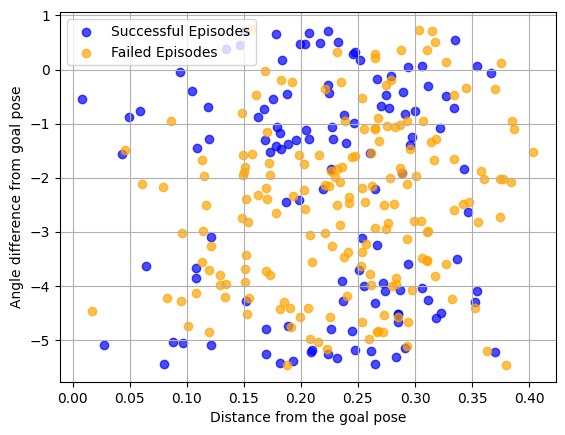

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Scatter plots
ax.scatter(success_ep_diff[:, 0], success_ep_diff[:, 1],
           label='Successful Episodes', color='blue', alpha=0.7)
ax.scatter(failure_ep_diff[:, 0], failure_ep_diff[:, 1],
           label='Failed Episodes', color='orange', alpha=0.7)

# Labels and legend
ax.set_xlabel('Distance from the goal pose')
ax.set_ylabel('Angle difference from goal pose')
ax.legend()
# Grid
ax.grid(True)
# Display
plt.show()

There does not seem to be a ton any correlation between difference from the goal pose to start pose and the outcome of the rollout.

### Testing 